In [1]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os
import numpy
import torch
from torch import autocast
from torchvision import transforms as tfms
import torch.nn.functional as F

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer, logging
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, KDPM2DiscreteScheduler

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

In [6]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
#scheduler = KDPM2DiscreteScheduler(num_train_timesteps=1000, beta_start=)

# To the GPU we go!
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device);

In [7]:
birb_embed = torch.load('./birb-style/learned_embeds.bin')
herge_embed = torch.load('./herge-style/learned_embeds.bin')
indian_water_color_embed = torch.load('./indian-watercolor-portraits/learned_embeds.bin')
midjourney_embed = torch.load('./midjourney-style/learned_embeds.bin')
marc_allante_embed = torch.load('./style-of-marc-allante/learned_embeds.bin')

In [84]:
style_seeds = {
    'birb': 321,
    'herge': 1,
    'indian_watercolor': 42,
    'midjourney': 8081,
    'marc_allante': 100
}

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path,torch_dtype=torch.float16).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [45]:
def purple_loss(images):
    # How far are the blue channel values to 0.9:
    #error = 0.0
    error = torch.abs(images[:,0] - 0.1).mean() # [:,2] -> all images in batch, only the blue channel
    error += torch.abs(images[:, 0] - 0.1).mean()
    return error

In [60]:
import cv2
bb = cv2.imread("./qr_code1.png")
bb = cv2.cvtColor(bb, cv2.COLOR_BGR2RGB) 
tfm2 = tfms.Compose([ 
    tfms.ToTensor(),
    tfms.Resize([512, 512]),
    tfms.CenterCrop(512),
    #tfms.Normalize((0.6813,0.6813, 0.6813), (0.4549, 0.4549, 0.4549))
]) 
img2 = tfm2(bb)

/tts_data/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [72]:
def qr_loss(images, qr_img):

    #qr_img = 0.5 * qr_img
    qr_img = qr_img.unsqueeze(0).to(device)
    #error = F.mse_loss(images, qr_img, reduction='mean')
    error = F.l1_loss(images, qr_img, reduction='mean')
    
    return error

In [11]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

In [12]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [13]:
def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 11               # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1
    loss_scale = 200

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [14]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    #causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)
    causal_attention_mask = build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready
    return output

In [15]:
def build_causal_attention_mask(bsz, seq_len, dtype):
    # lazily create causal attention mask, with full attention between the vision tokens
    # pytorch uses additive attention mask; fill with -inf
    mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    return mask

In [82]:
def generate_with_embs_custom_loss(prompt, text_embeddings, seed):
    #prompt = "A labrador dog in a car" #@param
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #@param           # Number of denoising steps
    guidance_scale = 11 #@param               # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    blue_loss_scale = 100 #@param

    # Prep text
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%2 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            #loss = blue_loss(denoised_images) * blue_loss_scale
            #loss = purple_loss(denoised_images) * blue_loss_scale
            loss = qr_loss(denoised_images, img2) * blue_loss_scale

            # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [86]:
def get_textual_inversion(prompt, style):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(device)
    
    # Tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(device)
    
    # Get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)
    
    # The new embedding - our special birb word
    if style == "birb":
        style_embed = birb_embed
    elif style == "herge":
        style_embed = herge_embed
    elif style == "indian_watercolor":
        style_embed = indian_water_color_embed
    elif style == "midjourney":
        style_embed = midjourney_embed
    elif style == "marc_allante":
        style_embed = marc_allante_embed
    replacement_token_embedding = style_embed[list(style_embed.keys())[0]].to(device)
    
    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(device)
    
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    
    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings
    
    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)
    
    # And generate an image with this:
    #generate_with_embs(modified_output_embeddings)
    
    imgf = generate_with_embs_custom_loss(prompt, modified_output_embeddings, style_seeds[style])
    return imgf

In [91]:
imgs = []
prompt = "A picture of James Bond wearing a cowboy hat in the style of puppy"
for s in ["birb", "indian_watercolor", "herge", "midjourney", "marc_allante"]:
    imgs.append(get_textual_inversion(prompt, s))

/tmp/ipykernel_366300/3684058939.py:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 34.488162994384766
10 loss: 30.71858024597168
20 loss: 29.3924560546875
30 loss: 28.67266845703125
40 loss: 28.24456787109375


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 34.924991607666016
10 loss: 33.593910217285156
20 loss: 33.40906524658203
30 loss: 32.556514739990234
40 loss: 32.20846176147461


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 35.71476364135742
10 loss: 34.8618278503418
20 loss: 33.82271194458008
30 loss: 33.51757049560547
40 loss: 33.375179290771484


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 42.4284553527832
10 loss: 27.513324737548828
20 loss: 27.30829429626465
30 loss: 26.941335678100586
40 loss: 26.883304595947266


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 34.97701644897461
10 loss: 35.21131896972656
20 loss: 34.05989074707031
30 loss: 33.4833869934082
40 loss: 32.988460540771484


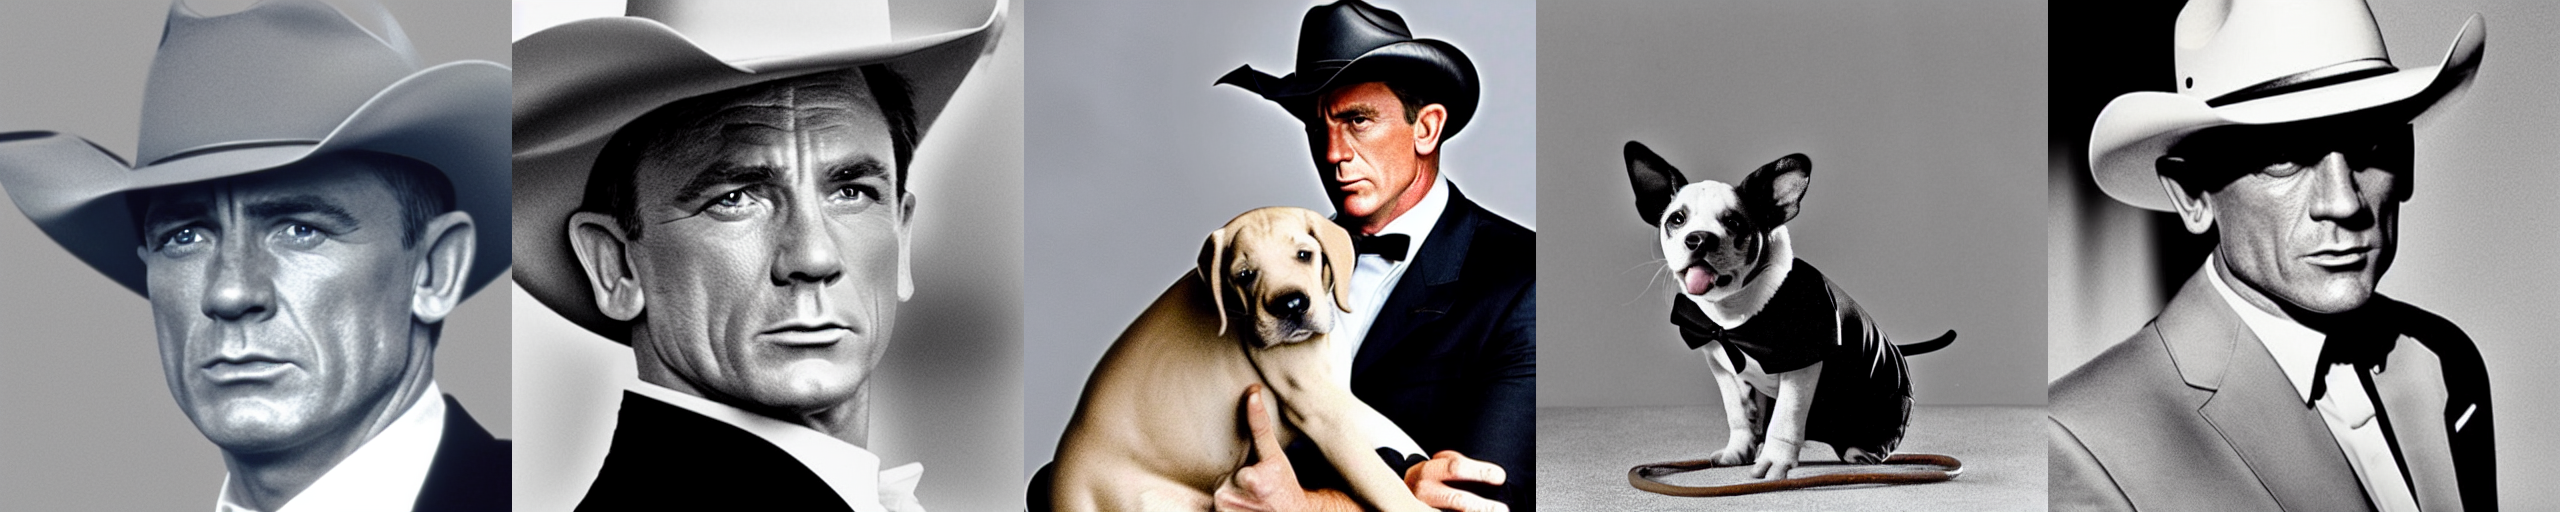

In [92]:
image_grid(imgs, 1, 5)